### Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

2024-07-10 10:57:19.017744: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 10:57:19.025922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 10:57:19.037401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 10:57:19.037424: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 10:57:19.044523: I tensorflow/core/platform/cpu_feature_gua

In [2]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [3]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [4]:
processed_texts[:5]

['need advice appreciate people will will super aggressive control 6 month ago cheat girlfriend tell shortly feel like shit remind come get bad want stay thought linger way closure come thank advance hope y’ hate',
 'dear Magic Eye Bot hate wanna T',
 'teacher sub right wrong answer assignment clearly personal choice',
 'officially close 30 year age 10 goodbye r teenager fun today reach age subreddit long target good thing care cause mind 12',
 'sure royal family racism thing interesting you hear conspiracy kidnap child own cult shit wild surprised queen live']

In [5]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

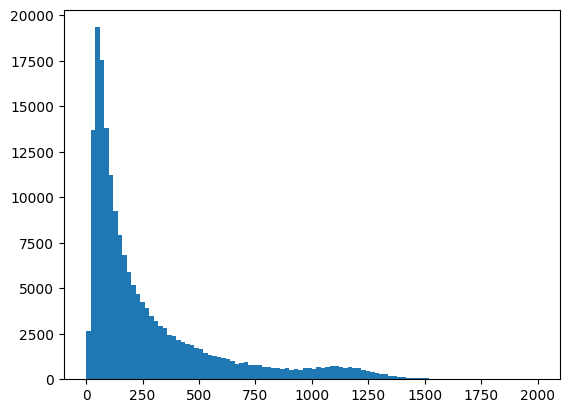

In [6]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [7]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

2024-07-10 10:57:20.536375: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-07-10 10:57:20.536398: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: kdesktop
2024-07-10 10:57:20.536405: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: kdesktop
2024-07-10 10:57:20.536461: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.183.1
2024-07-10 10:57:20.536479: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.183.1
2024-07-10 10:57:20.536485: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 535.183.1


In [9]:
vectorized_texts = vectorize_layer(processed_texts)

In [10]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

#### Creating the model

In [11]:
Sequential = keras.models.Sequential
from keras_tuner import HyperParameters as hp
from keras_tuner import RandomSearch

def build_model(hp):
    """Base Model Bidirectional Layer LSTM cells"""
    model = Sequential([
            keras.layers.Embedding(3000, 16),
        keras.layers.Bidirectional(keras.layers.LSTM(units = hp.Int('units', min_value=10, max_value=30, step=10), return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(units = hp.Int('units', min_value=10, max_value=30, step=10))),
        keras.layers.Dense(1, activation = hp.Choice('activation', ['sigmoid', 'hard_sigmoid', 'elu', 'leaky_relu']))
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

def build_model_2(hp):
    model = Sequential([
            keras.layers.Embedding(3000, 16),
        keras.layers.RNN(keras.layers.LSTM(units = hp.Int('units', min_value=10, max_value=30, step=10), return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(units = hp.Int('units', min_value=10, max_value=30, step=10))),
        keras.layers.Dense(1, activation = hp.Choice('activation', ['sigmoid', 'hard_sigmoid', 'elu', 'leaky_relu']))
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [ ]:
tuner = RandomSearch(
	build_model,
	objective='val_accuracy',
	max_trials=3,
	executions_per_trial=1,
	directory='../runs',
	project_name='tuner1'
)

tuner2 = RandomSearch(
	build_model_2,
	objective='val_accuracy',
	max_trials=3,
	executions_per_trial=1,
	directory='../runs',
	project_name='tuner2'
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(vectorized_texts, labels, epochs=5, validation_data=(vectorized_val_texts, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

### Tuner Results

In [ ]:
tuner.results_summary()

### Evaluating the Model

In [ ]:
best_model = tuner.get_best_models(num_models=1)
best_model = best_model[0]
best_model.summary()

In [ ]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

In [ ]:
_ = best_model.evaluate(vectorized_test_texts, test_labels)

726/726 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9402 - loss: 0.1643


In [ ]:
y_pred = best_model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)

y_pred = np.array(list(map(lambda x: x[0], y_pred)))

726/726 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

False Positive Rate: 0.0586
False Negative Rate: 0.0642


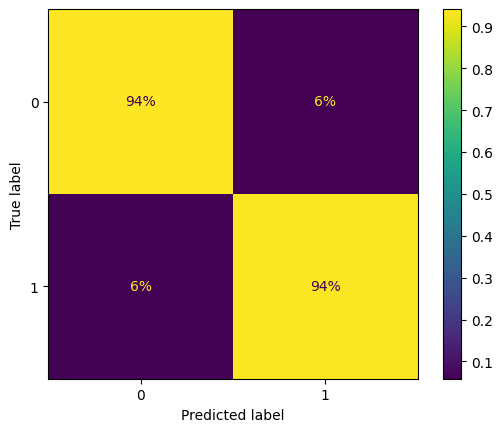

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()